In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
!pip install seaborn

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

In [4]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df = df.iloc[:500, :]
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1), dtype=float)
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [5]:
from sklearn.linear_model import LogisticRegression
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = LogisticRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.860000,1
Balanced Accuracy,0.697832,1
Precision,0.666667,1
Recall,0.444444,1
F1-Score,0.533333,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [6]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_pred)

In [7]:
permutation_explainer.metrics()

,Value,Reference
Fourth Fifths,1.000000,0
Importance Spread Divergence,3.550071,-
Importance Spread Ratio,0.225715,0
Global Overlap Score,0.526416,1
Global Range Overlap Score,0.956934,1
Global Similarity Score,0.878558,1
Global Explainability Ease Score,1.000000,1


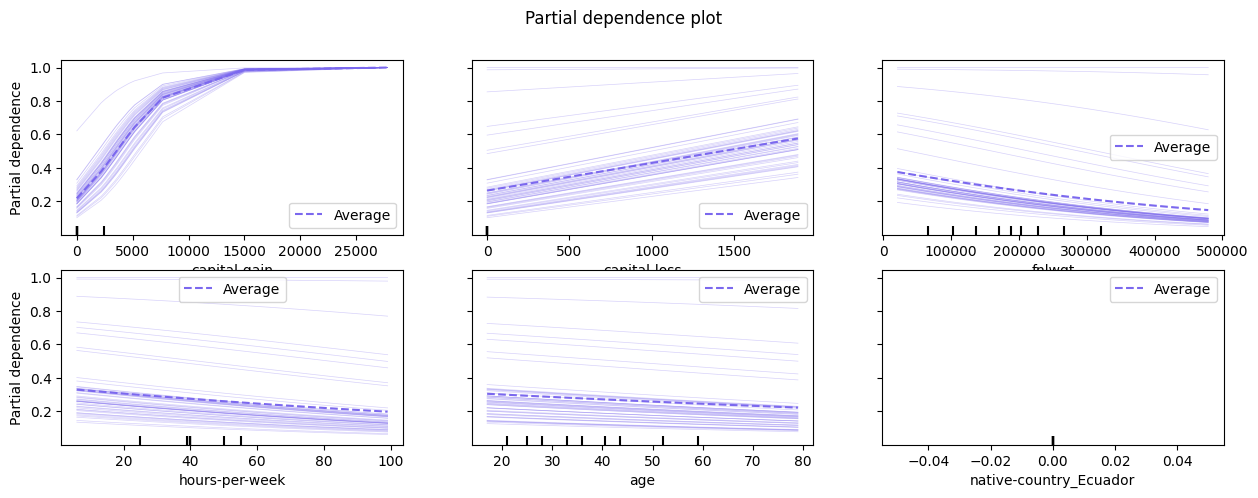

In [8]:
_,ax = plt.subplots(figsize=(15,5))
permutation_explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

In [9]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,1.000000,0
Importance Spread Divergence,3.550071,-
Importance Spread Ratio,0.225715,0
Global Overlap Score [label=0],0.052831,1
Global Overlap Score [label=1],1.000000,1
Global Range Overlap Score [label=0],0.913868,1
Global Range Overlap Score [label=1],1.000000,1
Global Similarity Score [label=0],0.821415,1
Global Similarity Score [label=1],0.935700,1
Global Explainability Ease Score,1.000000,1


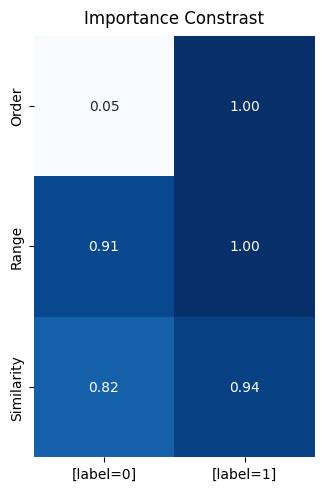

In [10]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

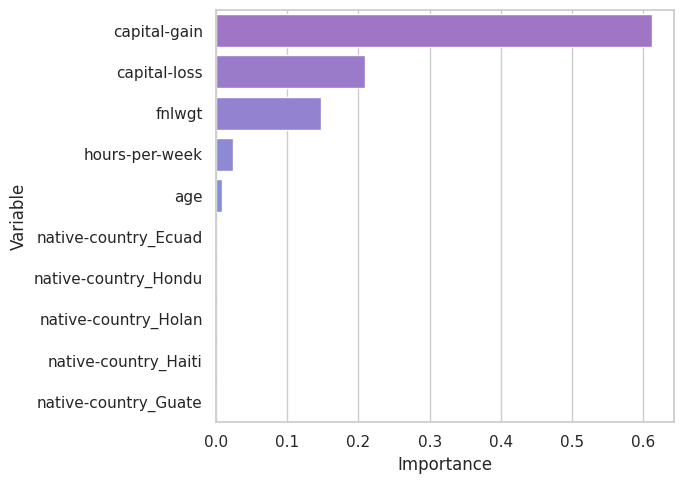

In [11]:
permutation_explainer.bar_plot(max_display=10)

In [12]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.612403,0.444444,0.382979
capital-loss,0.209302,0.000000,0.234043
fnlwgt,0.147287,0.333333,0.191489
hours-per-week,0.023256,0.222222,0.106383
age,0.007752,0.000000,0.085106


In [13]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [14]:
surrogate_explainer.metrics()

,Value,Reference
Fourth Fifths,1.000000,0
Importance Spread Divergence,3.934932,-
Importance Spread Ratio,0.141775,0
Global Explainability Ease Score,1.000000,1
Surrogate Efficacy Classification,0.812000,1


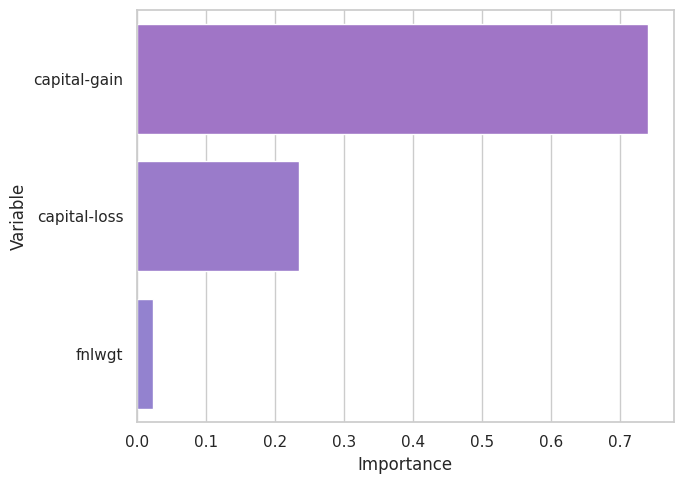

In [15]:
surrogate_explainer.bar_plot(max_display=3)

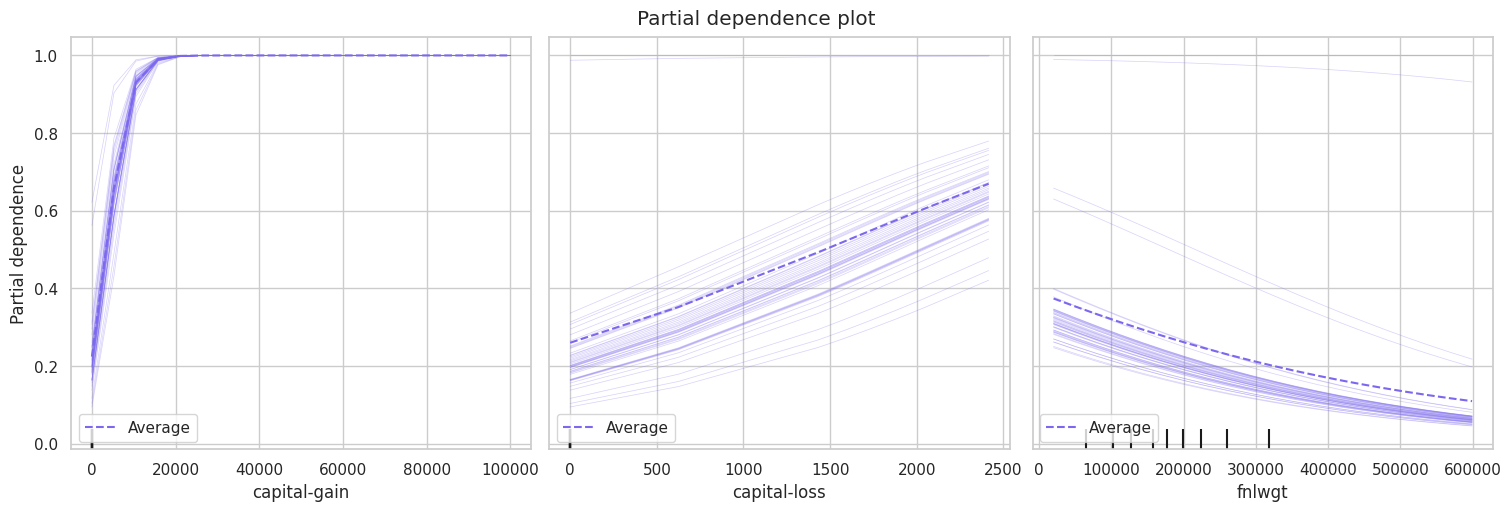

In [16]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=3, ax=ax, kind='both')

In [17]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
capital-gain,0.741089
capital-loss,0.235700
fnlwgt,0.023211
education_Preschool,0.000000
education-num,0.000000
hours-per-week,0.000000
workclass_Federal-gov,0.000000
workclass_Local-gov,0.000000
workclass_Never-worked,0.000000


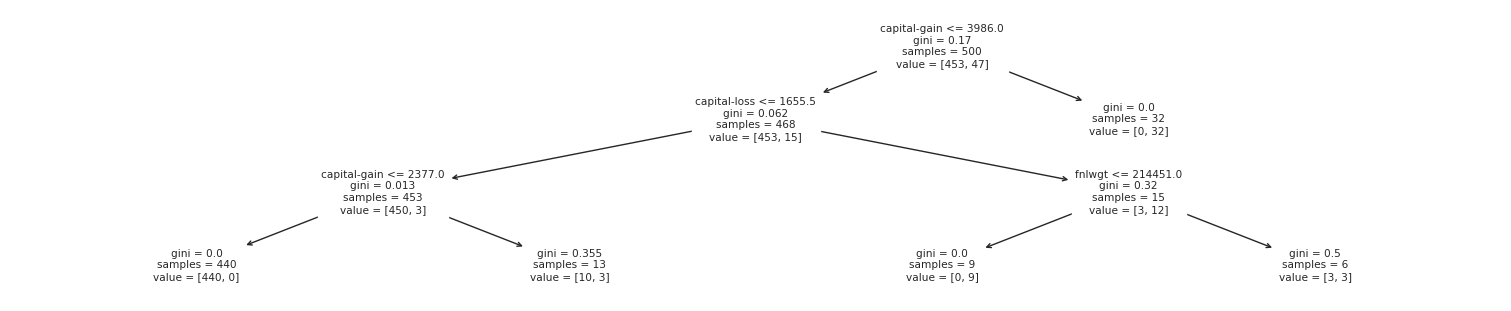

In [18]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

In [25]:
!pip install pydotplus dtreeviz

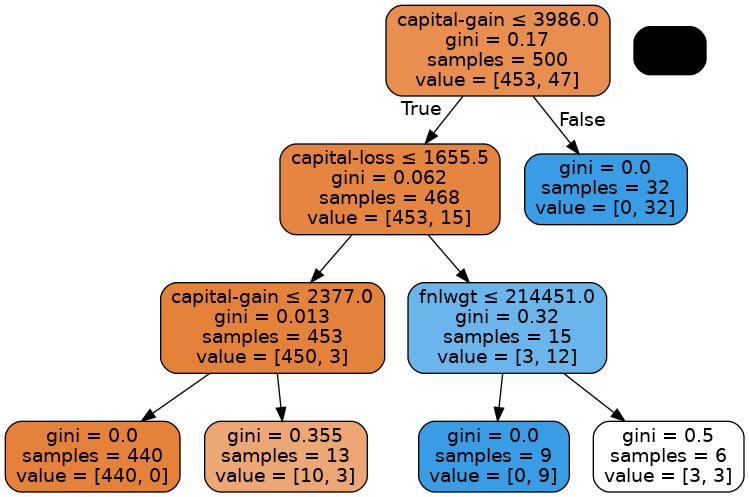

In [22]:
surrogate_explainer.tree_visualization('pydotplus')

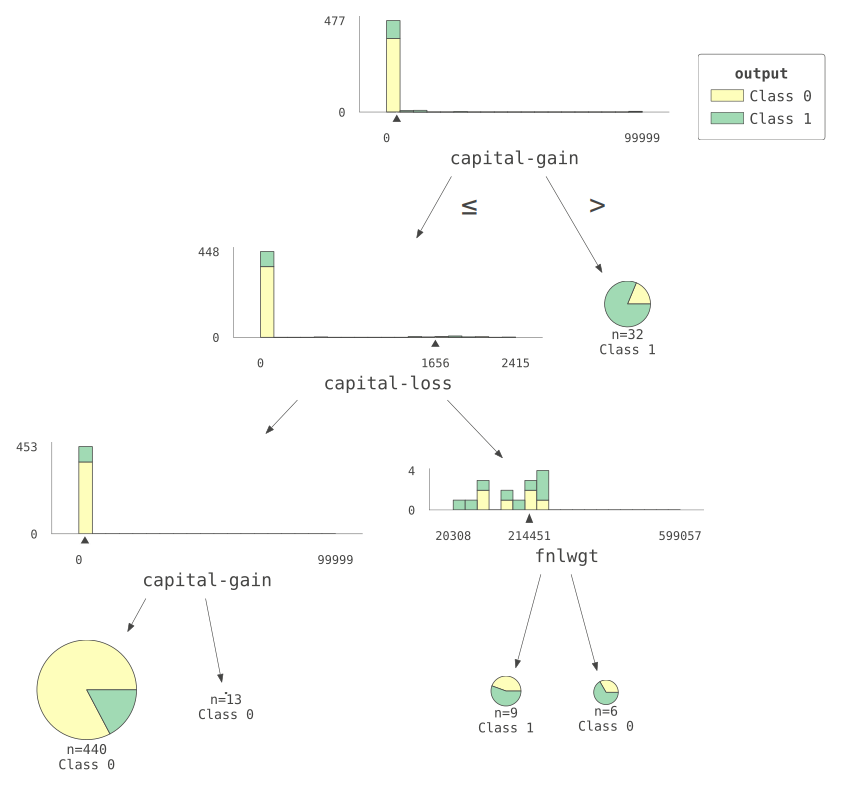

In [26]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [27]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [28]:
lime_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.045998,0
Features Stability Gini,0.081336,0


In [29]:
lime_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.045998,0
Dataset Stability Gini [label=0],0.042658,0
Dataset Stability Gini [label=1],0.052785,0
Features Stability Gini,0.081336,0
Features Stability Gini [label=0],0.091172,0
Features Stability Gini [label=1],0.120299,0


In [30]:
lime_explainer['Dataset Stability Gini']

0.045997756726996734

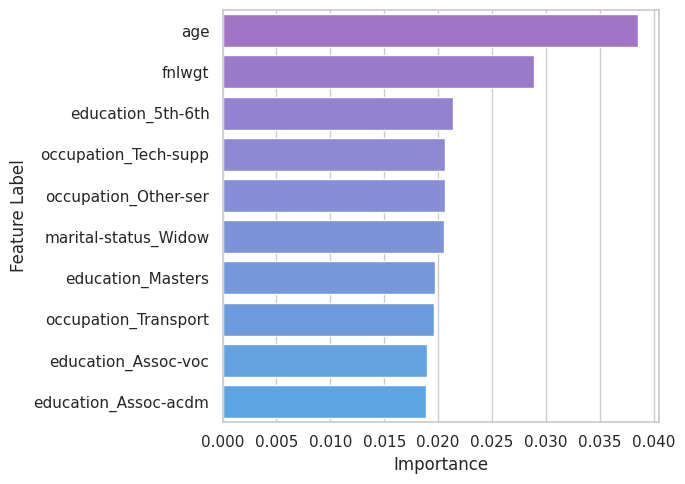

In [31]:
lime_explainer.bar_plot(max_display=10)

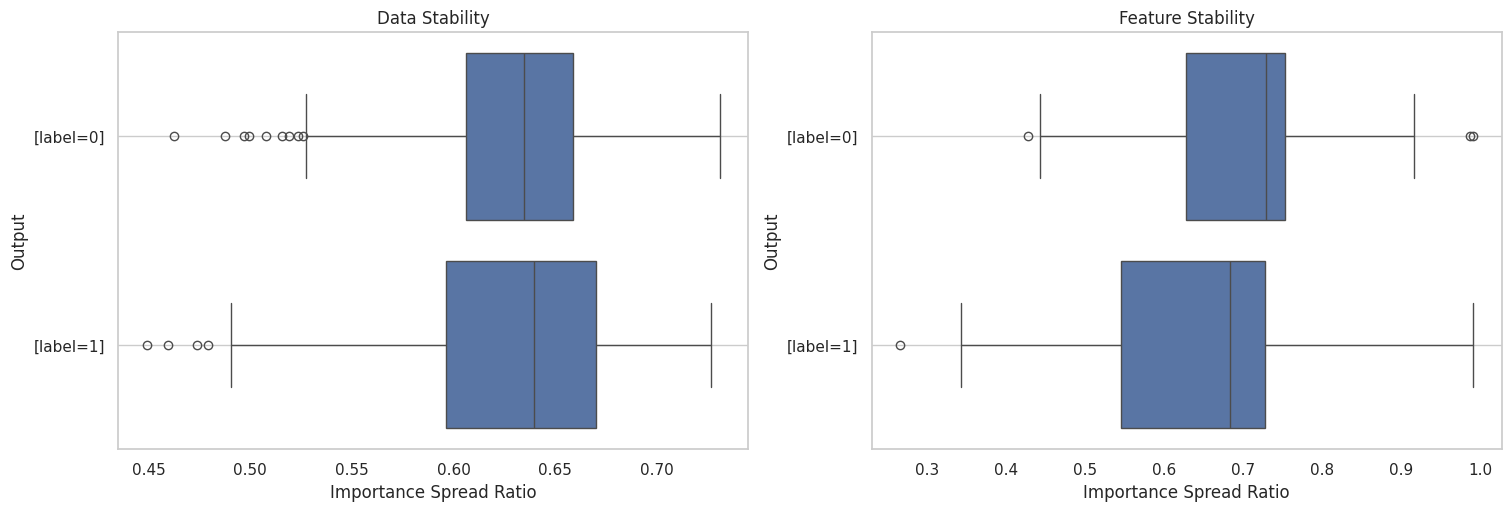

In [32]:
lime_explainer.show_importance_stability()

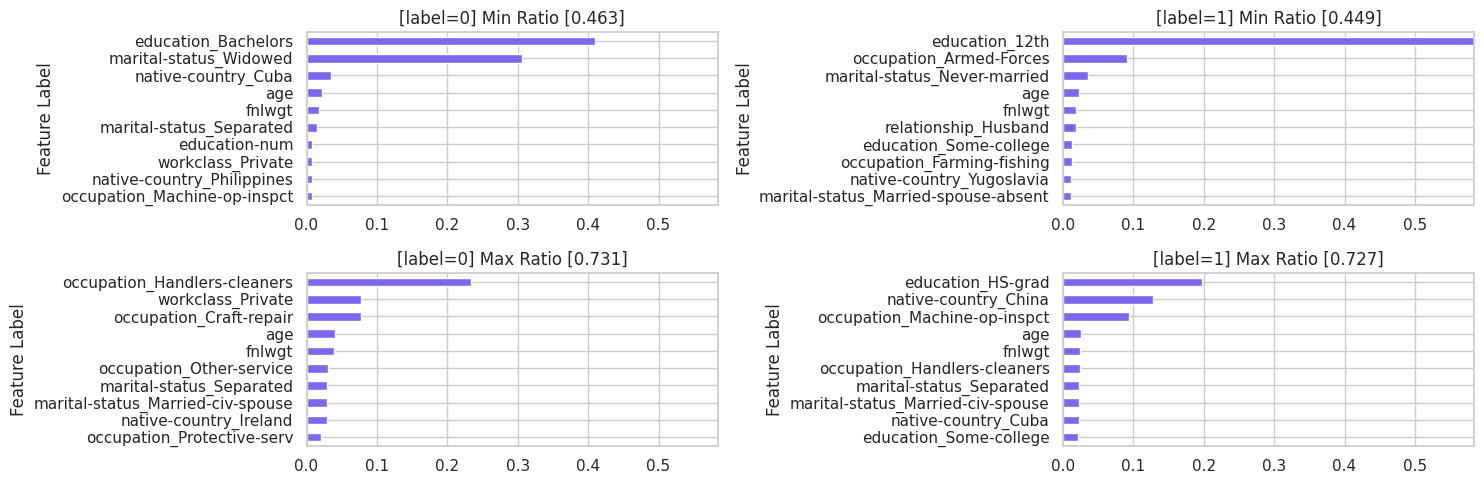

In [36]:
lime_explainer.show_data_stability_boundaries(top_n=10, n_cols=2, figsize=(15,5))

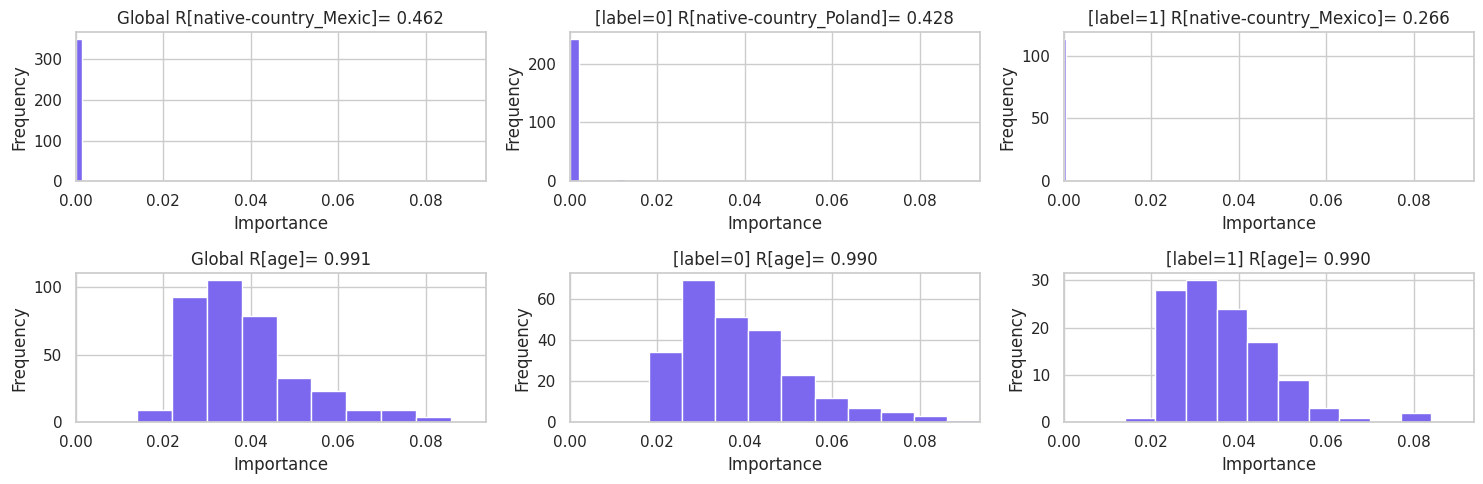

In [35]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))

# Local Explainability Metrics (SHAP)

In [37]:
# lime feature importance
shap_explainer = Explainer(based_on='feature_importance',
                      strategy_type='shap',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

Permutation explainer: 366it [00:13, 12.11it/s]                         


In [38]:
shap_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.122706,0
Features Stability Gini,0.073745,0


In [39]:
shap_explainer['Dataset Stability Gini']

0.12270600082677156

In [40]:
shap_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.122706,0
Dataset Stability Gini [label=0],0.069860,0
Dataset Stability Gini [label=1],0.231548,0
Features Stability Gini,0.073745,0
Features Stability Gini [label=0],0.074937,0
Features Stability Gini [label=1],0.029467,0


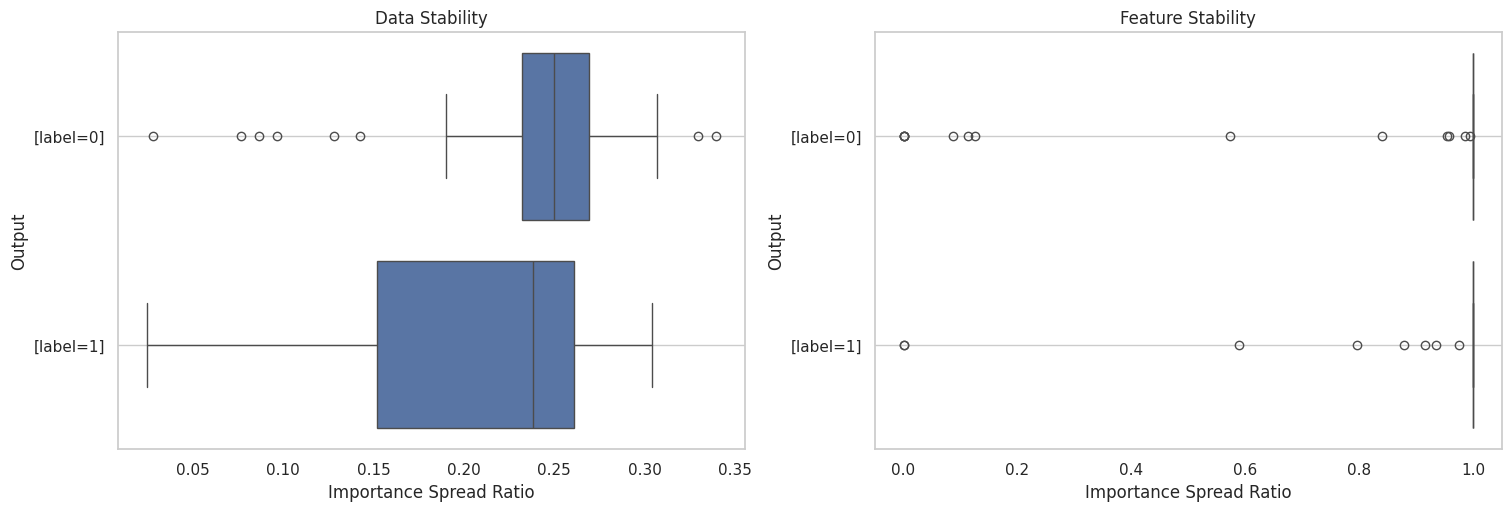

In [41]:
shap_explainer.show_importance_stability()

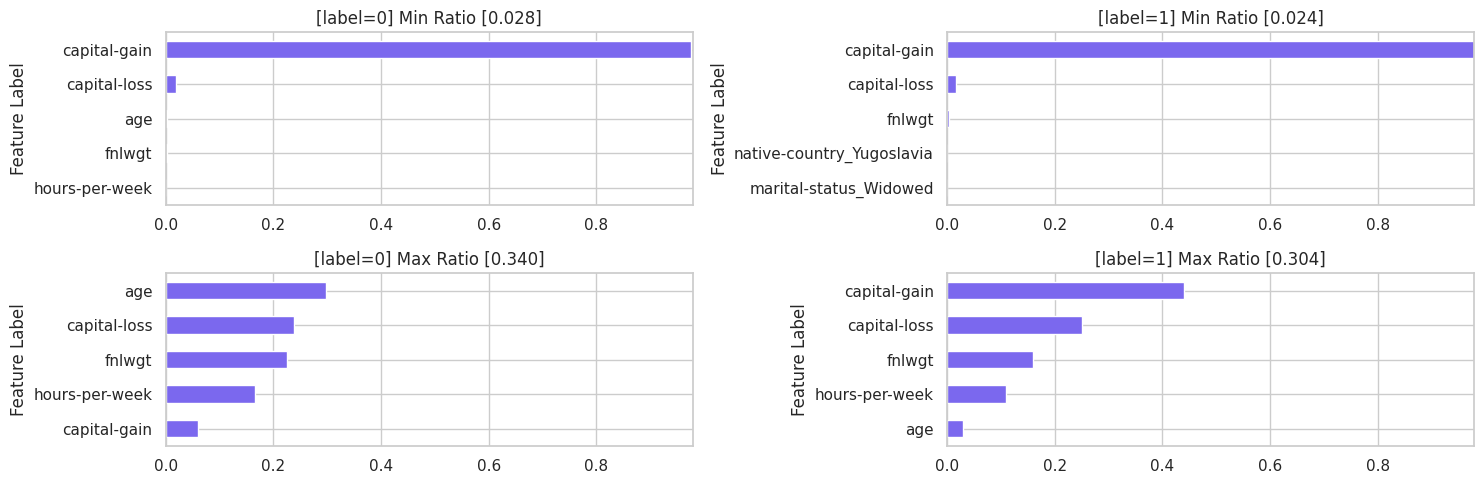

In [44]:
shap_explainer.show_data_stability_boundaries(top_n=5, n_cols=2, figsize=(15,5))

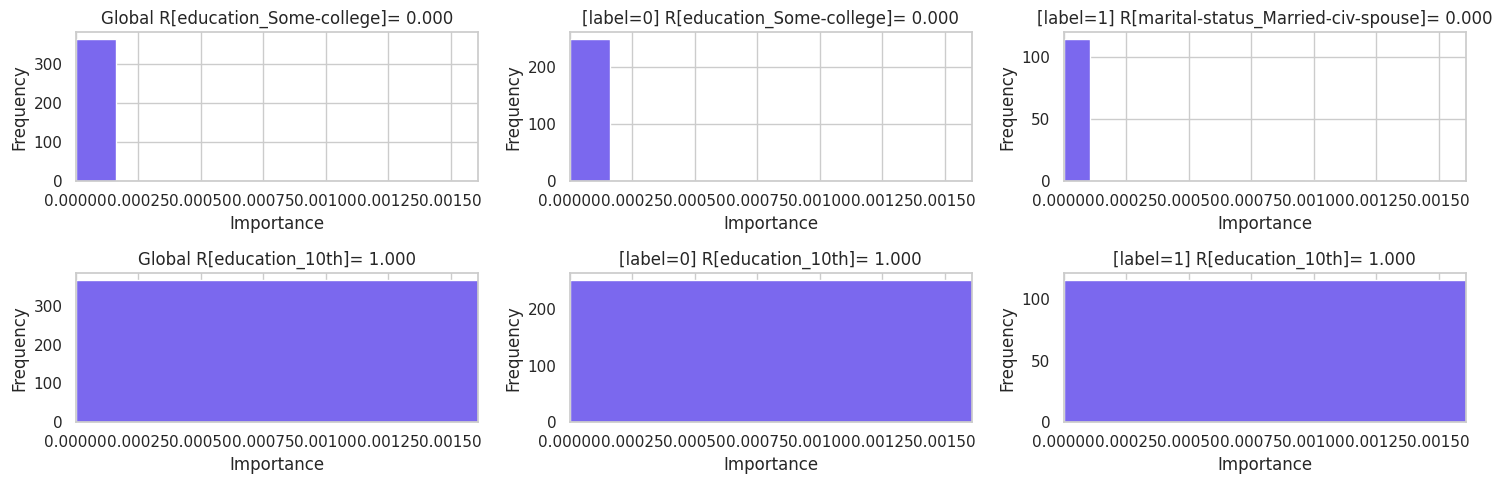

In [43]:
shap_explainer.show_features_stability_boundaries(figsize=(15,5))